<a href="https://colab.research.google.com/github/anphantt2406/Heritage-Health-Prize/blob/main/3_Model_withFeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/HHP_release3/new_data

Mounted at /content/drive
/content/drive/My Drive/HHP_release3/new_data


#Import Library

In [2]:
import glob
import math
import pandas as pd
import numpy as np
import xgboost
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.neural_network import MLPRegressor
from sklearn import datasets, ensemble
from sklearn.datasets import make_regression

import seaborn as sns # Library for plotting
color = sns.color_palette()
sns.set_style('darkgrid')
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#Define some needed function

Predictions are evaluated using root mean squared logarithmic error, referred to henceforth as RMSLE.

$$\varepsilon = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(log(p_i+1) - log(a_i+1)^2 \right )}$$

Where:



*   $i$ is a patient's unique MemberID
*   $n$ is the total number of patients
*   $p_i$ is the prediction made for patient $i$
*   $a_i$ is the actual number of days spent in the hospital by patient $i$





In [3]:
def RMSLE_cal(pred, actu, name=None):
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    print('RMSLE', name, ':', RMSLE)

In [4]:
def rmsle(pred, dtrain):
    """Used for stacked in Xgboost
    """
    actu = dtrain.get_label()
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    return 'RMSLE', RMSLE

In [5]:
def eval(model, X_test, y_test, name = None):
    pred_y = model.predict(X_test) # your predicted y values
    # The root mean square logarithmic error
    pred_y = pred_y.clip(min=0)
    pred_y = pred_y.clip(max=15)
    pred_y = pred_y.round(0).astype(int)
    msle = np.mean( (np.log(pred_y + 1) - np.log(y_test + 1)) ** 2)
    rmsle = math.sqrt(msle)
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test,pred_y)
    from sklearn.metrics import mean_squared_log_error
    err = math.sqrt(mean_squared_log_error(y_test,pred_y))
    print("RMSLE of", name, ": %.4f" %rmsle)
    print("R2 value of", name, ": %.4f" %r2)
    print("Err value of", name, ": %.4f" %err)

In [6]:
def plotResult(results, cv=None):
    fig, ax = plt.subplots()
    if cv:
        ax.plot(range(results.shape[0]), results['train-RMSLE-mean'])
        ax.plot(range(results.shape[0]), results['test-RMSLE-mean'])
    else:
        ax.plot(range(len(results['train']['RMSLE'])), results['train']['RMSLE'])
        ax.plot(range(len(results['test']['RMSLE'])), results['test']['RMSLE'])
        
    ax.set(xlabel='Boost round', ylabel='RMSLE', title='Train/Test RMSLE')
    ax.grid()

    train_patch = mpatches.Patch(color='blue', label='Train')
    test_patch = mpatches.Patch(color='orange', label='Test')

    plt.legend(handles=[train_patch, test_patch])
    plt.show()

#Prepare data for training and testing
In this notebook, we use Claims data in Year 1 for training and validation, Claims data in Year 2 for testing.

Moreover, we only extract some features which have correlation with target $> 0.1$ and with others $< 0.9$

(Please take a look at FeatureSelection file).

In [7]:
dataY1_df = pd.read_csv('fulldataY1.csv')
dataY2_df = pd.read_csv('fulldataY2.csv')
data_selected = pd.read_csv('FeatureSelection_data.csv')
cols = list(data_selected.columns)

In [8]:
dataY1_df = dataY1_df[['MemberID',
 'AgeAtFirstClaim',
 'Unknown',
 'no_Claims',
 'no_Providers',
 'no_Specialties',
 'no_PCG',
 'no_Procedure',
 'sum_PayDelay',
 'Specialty_Diagnostic Imaging',
 'Specialty_Emergency',
 'Specialty_Internal',
 'Specialty_Laboratory',
 'Place_Inpatient Hospital',
 'Place_Office',
 'Place_Urgent Care',
 'DSFS_10-11 months',
 'DSFS_6- 7 months',
 'DSFS_7- 8 months',
 'DSFS_8- 9 months',
 'Charlson_1-2',
 'Procedure_EM',
 'Procedure_MED',
 'Procedure_RAD',
 'DrugSum',
 'LabSum',
 'TARGET']]

dataY2_df = dataY2_df[['MemberID',
 'AgeAtFirstClaim',
 'Unknown',
 'no_Claims',
 'no_Providers',
 'no_Specialties',
 'no_PCG',
 'no_Procedure',
 'sum_PayDelay',
 'Specialty_Diagnostic Imaging',
 'Specialty_Emergency',
 'Specialty_Internal',
 'Specialty_Laboratory',
 'Place_Inpatient Hospital',
 'Place_Office',
 'Place_Urgent Care',
 'DSFS_10-11 months',
 'DSFS_6- 7 months',
 'DSFS_7- 8 months',
 'DSFS_8- 9 months',
 'Charlson_1-2',
 'Procedure_EM',
 'Procedure_MED',
 'Procedure_RAD',
 'DrugSum',
 'LabSum',
 'TARGET']]

In [9]:
dataY1_df

,MemberID,AgeAtFirstClaim,Unknown,no_Claims,no_Providers,no_Specialties,no_PCG,no_Procedure,sum_PayDelay,Specialty_Diagnostic Imaging,Specialty_Emergency,Specialty_Internal,Specialty_Laboratory,Place_Inpatient Hospital,Place_Office,Place_Urgent Care,DSFS_10-11 months,DSFS_6- 7 months,DSFS_7- 8 months,DSFS_8- 9 months,Charlson_1-2,Procedure_EM,Procedure_MED,Procedure_RAD,DrugSum,LabSum,TARGET
0,210,35,1,8,4,3,4,5,720,0,2,4,2,0,4,2,0,1,0,0,0,1,4,0,5,2,0
1,3197,5,0,5,3,2,2,2,492,0,2,0,0,0,3,2,0,0,0,0,0,4,0,0,5,0,0
2,3889,45,0,13,7,4,5,5,919,1,4,4,4,0,4,5,0,0,0,0,4,5,0,1,30,10,0
3,4187,55,0,4,3,3,3,2,340,1,0,2,0,0,4,0,0,0,0,1,0,3,0,1,61,0,0
4,9063,65,0,4,2,2,1,2,241,1,0,3,0,0,4,0,0,0,0,0,0,2,0,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76033,99995554,45,0,35,3,3,3,4,3899,0,0,26,7,0,28,0,0,7,7,4,0,4,24,0,8,11,0
76034,99996214,45,0,1,1,1,1,1,19,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
76035,99997485,15,0,1,1,1,1,1,130,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
76036,99997895,45,0,14,5,4,6,4,539,1,0,4,7,0,7,0,0,0,0,3,0,6,0,1,0,10,0


In [10]:
dataY1 = dataY1_df.drop("MemberID", axis = 1)
y = dataY1['TARGET']
X = dataY1.drop(['TARGET'], axis = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)


dataY2 = dataY2_df.drop("MemberID", axis = 1)
y_test = dataY2['TARGET']
X_test = dataY2.drop(['TARGET'], axis = 1)

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Regression

## MODEL 1: Linear Regression

RMSLE of linear regression : 0.5355
R2 value of linear regression : 0.0348
Err value of linear regression : 0.5355


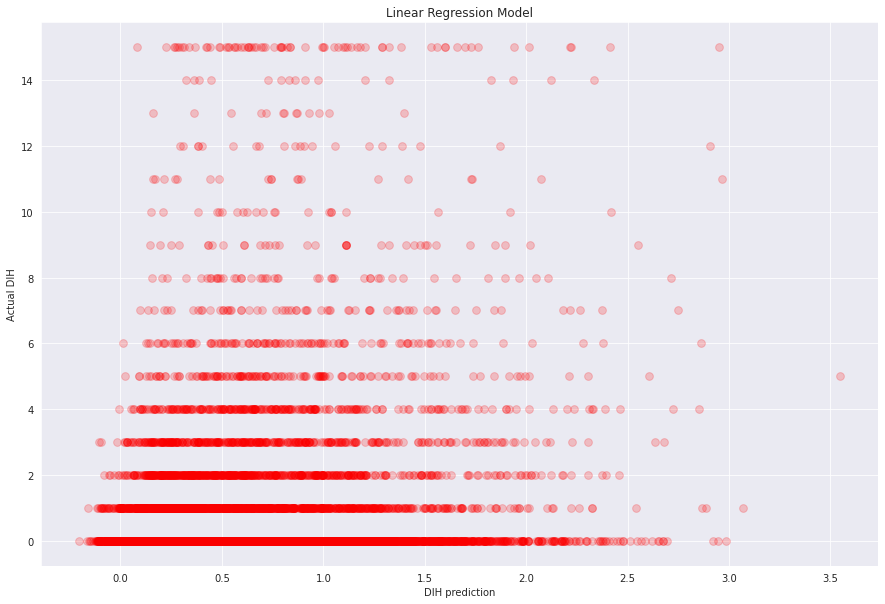

In [12]:
# Create linear regression object
model_1 = LinearRegression()
# Train the model using the training sets
model_1.fit(X_train, y_train)
# Predict on Test set
y_pred_1 = model_1.predict(X_valid)

# Evaluation on Validation set
eval(model_1, X_valid, y_valid,'linear regression')

plt.figure(figsize = (15,10))
plt.scatter(y_pred_1, y_valid, alpha=.2, s = 60, color='r') #alpha helps to show overlapping data
plt.xlabel('DIH prediction')
plt.ylabel('Actual DIH')
plt.title('Linear Regression Model')
plt.show()

## MODEL 2: Stochastic Gradient Descent

In [13]:
from sklearn.linear_model import SGDRegressor

model_2 = SGDRegressor(max_iter=3000, tol=1e-1)
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_valid)
eval(model_2, X_valid, y_valid, 'Stochastic Gradient Descent')

RMSLE of Stochastic Gradient Descent : 0.5309
R2 value of Stochastic Gradient Descent : 0.0280
Err value of Stochastic Gradient Descent : 0.5309


In [14]:
model_2i = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=5000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False)
model_2i.fit(X_train, y_train)
eval(model_2i, X_valid, y_valid, 'Lasso regression')

RMSLE of Lasso regression : 0.5356
R2 value of Lasso regression : 0.0346
Err value of Lasso regression : 0.5356


##MODEL 3: Neural Network

In [15]:
#(i) Neural Network with default hyperparameters
model_3i = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
y_pred_3 = model_3i.predict(X_valid)
eval(model_3i, X_valid, y_valid, 'Neural Network_default')

RMSLE of Neural Network_default : 0.5667
R2 value of Neural Network_default : -0.0121
Err value of Neural Network_default : 0.5667


In [16]:
#(ii) random hyperparameter
model_3ii = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=7, learning_rate='adaptive',
        learning_rate_init=0.001, max_iter=3000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3ii.fit(X_train, y_train)
eval(model_3ii, X_valid, y_valid , 'Neural Network_random')

Iteration 1, loss = 1.58512972
Iteration 2, loss = 1.30859382
Iteration 3, loss = 1.24106011
Iteration 4, loss = 1.21977680
Iteration 5, loss = 1.21201395
Iteration 6, loss = 1.20878651
Iteration 7, loss = 1.20576503
Iteration 8, loss = 1.20439907
Iteration 9, loss = 1.20329894
Iteration 10, loss = 1.20209775
Iteration 11, loss = 1.20190648
Iteration 12, loss = 1.20058317
Iteration 13, loss = 1.20111468
Iteration 14, loss = 1.20013572
Iteration 15, loss = 1.19987785
Iteration 16, loss = 1.19956314
Iteration 17, loss = 1.19977961
Iteration 18, loss = 1.19923220
Iteration 19, loss = 1.19891777
Iteration 20, loss = 1.19898646
Iteration 21, loss = 1.19820300
Iteration 22, loss = 1.19801514
Iteration 23, loss = 1.19794110
Iteration 24, loss = 1.19842759
Iteration 25, loss = 1.19777233
Iteration 26, loss = 1.19770347
Iteration 27, loss = 1.19710883
Iteration 28, loss = 1.19744202
Iteration 29, loss = 1.19661499
Iteration 30, loss = 1.19697424
Iteration 31, loss = 1.19643918
Iteration 32, los

**Hyperparameter Optimization using Grid Search**

In [17]:
#parameter_grid = {'hidden_layer_sizes': [i for i in range(1,10)],
#                  'activation': ['tanh', 'relu'],
#                  'solver': ['sgd','adam'],
#                  'learning_rate': ['constant'],
#                  'learning_rate_init': [0.001],
#                  'alpha': [0.0001],
#                  'max_iter': [1000],}

#rgr = GridSearchCV(MLPRegressor(), parameter_grid,
#                   cv = 5, verbose=True, pre_dispatch='2*n_jobs')
#rgr.fit(X_train, y_train)

#train_mse = mean_squared_error(y_train, rgr.predict(X_train))
#test_mse = mean_squared_error(y_valid, rgr.predict(X_valid))

#print(rgr.best_params_)
#print(rgr.best_score_)
#print("Train MSE:", np.round(train_mse,2))
#print("Test MSE:", np.round(test_mse,2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 29.7min finished


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 9, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, 'solver': 'sgd'}
0.06602243093692983
Train MSE: 2.36
Test MSE: 2.53


In [18]:
from sklearn.neural_network import MLPRegressor

model_3 = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=9, learning_rate='constant',
        learning_rate_init=0.001, max_iter=1000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3.fit(X_train, y_train)
eval(model_3, X_valid, y_valid, 'Neural Network_gridsearch')

Iteration 1, loss = 1.30647398
Iteration 2, loss = 1.24815829
Iteration 3, loss = 1.23482084
Iteration 4, loss = 1.22739087
Iteration 5, loss = 1.22186633
Iteration 6, loss = 1.21832284
Iteration 7, loss = 1.21563971
Iteration 8, loss = 1.21330703
Iteration 9, loss = 1.21143728
Iteration 10, loss = 1.20970365
Iteration 11, loss = 1.20850694
Iteration 12, loss = 1.20708963
Iteration 13, loss = 1.20594709
Iteration 14, loss = 1.20550356
Iteration 15, loss = 1.20459469
Iteration 16, loss = 1.20387111
Iteration 17, loss = 1.20314995
Iteration 18, loss = 1.20244611
Iteration 19, loss = 1.20165610
Iteration 20, loss = 1.20146502
Iteration 21, loss = 1.20092405
Iteration 22, loss = 1.20062366
Iteration 23, loss = 1.20033191
Iteration 24, loss = 1.20001563
Iteration 25, loss = 1.19937298
Iteration 26, loss = 1.19899607
Iteration 27, loss = 1.19860734
Iteration 28, loss = 1.19854273
Iteration 29, loss = 1.19795159
Iteration 30, loss = 1.19794938
Iteration 31, loss = 1.19742721
Iteration 32, los

## MODEL 4: XGBoost -  Gradient Boost Linear Regression Function

In [21]:
reg = ensemble.GradientBoostingRegressor(n_estimators = 500,
          max_depth = 4,
          min_samples_split= 5,
          learning_rate = 0.01,
          loss = 'ls')
reg.fit(X_train, y_train)
eval(reg, X_valid, y_valid,'Gradient Boosting Regressor')

RMSLE of GradientBoostingRegressor : 0.5315
R2 value of GradientBoostingRegressor : 0.0391
Err value of GradientBoostingRegressor : 0.5315


In [19]:
# Set XGBoost DataMatrix
dmatrix_train = xgboost.DMatrix(data=X_train,label=y_train)
dmatrix_test = xgboost.DMatrix(data=X_test,label=y_test)

[04:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:1.52576	train-rmse:1.59697	test-RMSLE:0.521023	train-RMSLE:0.529429
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.52036	train-rmse:1.59226	test-RMSLE:0.517703	train-RMSLE:0.525714
[2]	test-rmse:1.51631	train-rmse:1.58869	test-RMSLE:0.515302	train-RMSLE:0.522921
[3]	test-rmse:1.51324	train-rmse:1.58597	test-RMSLE:0.513517	train-RMSLE:0.52078
[4]	test-rmse:1.51088	train-rmse:1.58387	test-RMSLE:0.512154	train-RMSLE:0.519104
[5]	test-rmse:1.50905	train-rmse:1.58222	test-RMSLE:0.511086	train-RMSLE:0.517769
[6]	test-rmse:1.50761	train-rmse:1.58093	test-RMSLE:0.510228	train-RMSLE:0.516687
[7]	test-rmse:1.50647	train-rmse:1.57991	test-RMSLE:0.509524	train-RMSLE:0.515797
[8]	test-rmse:1.50557	train-rmse:1.57909	test-RMSLE:0.508935	train-RMSLE

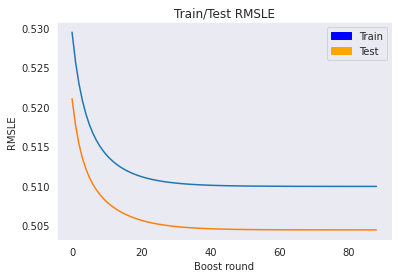

RMSLE Train set: 0.509943


In [20]:
# XGBoost
params = {'objective': 'reg:linear', 'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.5, 'learning_rate': 0.1, 'max_depth': 15, 'lambda': 10,
          'booster': 'gblinear'}
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])

# Final Results

In [22]:
eval(model_1, X_test, y_test,'linear regression')
print('******')
eval(model_2, X_test, y_test, 'Stochastic Gradient Descent')
print('******')
eval(model_2i, X_test, y_test, 'Lasso regression')
print('******')
eval(model_3i, X_test, y_test, 'Neural Network_randomn')
print('******')
eval(model_3ii, X_test, y_test, 'Neural Network_random')
print('******')
eval(model_3, X_test, y_test, 'Neural Network_gridsearch')
print('******')
eval(reg, X_test, y_test,'Gradient Boosting Regressor')
print('******')
print('Gradient Boost Linear Regression _ RMSLE Test set:', xgb_results['test']['RMSLE'][-1]) 


RMSLE of linear regression : 0.5343
R2 value of linear regression : 0.0252
Err value of linear regression : 0.5343
******
RMSLE of Stochastic Gradient Descent : 0.5260
R2 value of Stochastic Gradient Descent : 0.0201
Err value of Stochastic Gradient Descent : 0.5260
******
RMSLE of Lasso regression : 0.5336
R2 value of Lasso regression : 0.0251
Err value of Lasso regression : 0.5336
******
RMSLE of Neural Network_randomn : 0.5679
R2 value of Neural Network_randomn : -0.0544
Err value of Neural Network_randomn : 0.5679
******
RMSLE of Neural Network_random : 0.5330
R2 value of Neural Network_random : 0.0256
Err value of Neural Network_random : 0.5330
******
RMSLE of Neural Network_gridsearch : 0.5308
R2 value of Neural Network_gridsearch : 0.0235
Err value of Neural Network_gridsearch : 0.5308
******
RMSLE of Gradient Boosting Regressor : 0.5313
R2 value of Gradient Boosting Regressor : 0.0250
Err value of Gradient Boosting Regressor : 0.5313
******
Gradient Boost Linear Regression _ RM

In [23]:
pred_y = xgb_model.predict(dmatrix_test)

submission = pd.DataFrame()
submission['MemberID'] = dataY2_df['MemberID']

pred_y = pred_y.clip(min=0)
pred_y = pred_y.clip(max=15)
# pred_y = pred_y.astype(int)

submission['DIH'] = pred_y
submission.groupby(['DIH']).size()

DIH
0.257158    1
0.264758    1
0.266045    1
0.266266    1
0.266850    2
           ..
1.346197    1
1.371901    1
1.384831    1
1.386590    1
1.433072    1
Length: 69023, dtype: int64

In [24]:
submission[submission['DIH']>=1]

,MemberID,DIH
16,20072,1.039855
25,33120,1.083886
29,42758,1.160462
30,47103,1.005627
34,50035,1.025864
...,...,...
71175,99629004,1.030233
71176,99629632,1.078268
71226,99704112,1.224555
71248,99733425,1.069843


In [25]:
dataY2_df[dataY2_df['MemberID']==	99932868]

,MemberID,AgeAtFirstClaim,Unknown,no_Claims,no_Providers,no_Specialties,no_PCG,no_Procedure,sum_PayDelay,Specialty_Diagnostic Imaging,Specialty_Emergency,Specialty_Internal,Specialty_Laboratory,Place_Inpatient Hospital,Place_Office,Place_Urgent Care,DSFS_10-11 months,DSFS_6- 7 months,DSFS_7- 8 months,DSFS_8- 9 months,Charlson_1-2,Procedure_EM,Procedure_MED,Procedure_RAD,DrugSum,LabSum,TARGET
71389,99932868,45,1,42,13,6,9,7,1588,3,8,22,2,22,12,5,0,0,0,0,34,19,11,5,17,4,0
